In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Useful function (1)
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [3]:
# Useful function (2)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

In [4]:
### MNIST ###

In [5]:
# Download the MNIST dataset from openml
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X = mnist["data"]
y = mnist["target"]

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape

(56000, 784)

In [11]:
y_train.shape

(56000,)

In [12]:
X_test.shape

(14000, 784)

In [13]:
y_test.shape

(14000,)

In [14]:
# Convert labels from strings to integers
y_train = y_train.astype(np.uint8)
y_test  = y_test.astype(np.uint8)

In [15]:
y_train[0]

5

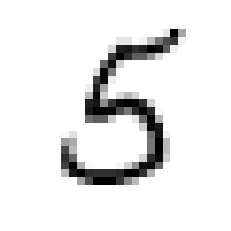

In [16]:
plot_digit(X_train[0])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

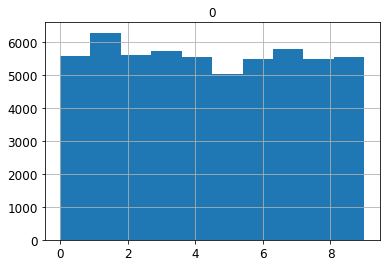

In [17]:
import pandas as pd

y_train_pd = pd.DataFrame(y_train)
y_train_pd.hist(bins=10)
# As you can see, the data is quite balanced

In [18]:
# Let's use TSNE for a better visualisation of the digits (in a 2D plane)

In [19]:
from sklearn.manifold import TSNE

# This cell takes ~5 minutes to run
tsne = TSNE(n_components=2, random_state=42)
X_train_red = tsne.fit_transform(X_train)

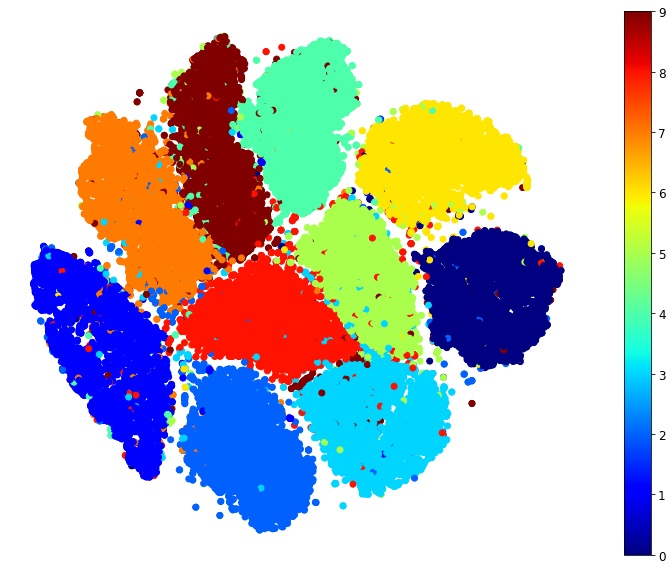

In [20]:
# Now let's use Matplotlib's scatter() function to plot a scatterplot, using different colors for each digit
plt.figure(figsize=(13, 10))
plt.scatter(X_train_red[:, 0], X_train_red[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()

In [21]:
# Let's try a multiclass classification algorithm

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [23]:
X_train_slice = X_train[:5000]
y_train_slice = y_train[:5000]

In [24]:
forest_clf.fit(X_train_slice, y_train_slice)

RandomForestClassifier(random_state=42)

In [25]:
from sklearn.metrics import accuracy_score

y_pred = forest_clf.predict(X_train[5000:7500])
accuracy_score(y_train[5000:7500], y_pred)

0.9364

In [26]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(forest_clf, X_train[15000:20000], y_train[15000:20000], cv=3, method="predict_proba")

In [27]:
y_pred_class = np.argmax(y_pred, axis=-1)
y_pred_class

array([6, 5, 2, ..., 2, 1, 5], dtype=int64)

In [28]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_train[15000:20000], y_pred_class)
conf_mat

array([[481,   0,   1,   0,   0,   0,   4,   0,   3,   0],
       [  0, 544,   5,   2,   1,   2,   3,   0,   2,   2],
       [  3,   4, 469,   6,   7,   0,   5,   9,   2,   1],
       [  2,   2,  11, 458,   0,  15,   2,   5,   9,   5],
       [  1,   0,   3,   0, 441,   0,  10,   1,   3,  27],
       [  7,   2,   1,   8,   7, 390,   8,   1,   6,   7],
       [  6,   2,   6,   0,   3,  10, 485,   0,   2,   0],
       [  1,   1,   8,   0,   8,   0,   0, 496,   0,  11],
       [  4,   6,   5,  16,   3,   3,   1,   0, 433,   7],
       [  2,   0,   0,   8,  13,   2,   2,   9,   3, 456]], dtype=int64)

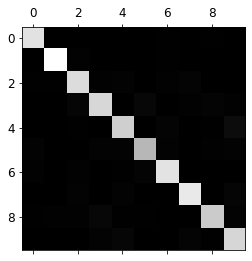

In [29]:
plt.matshow(conf_mat, cmap=plt.cm.gray)

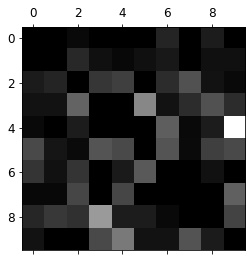

In [30]:
# Let's invert the matrix, focusing on the errors
rows_sum = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / rows_sum
np.fill_diagonal(norm_conf_mat, 0)

plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
# Rows = real classes
# Cols = predicted classses

In [31]:
# We can see that the rnd forest clf misclassify a lot of 4's as 9's

In [58]:
# We can define some useful functions for later usage

In [73]:
# Let's invert the matrix, focusing on the errors
# Rows = real classes
# Cols = predicted classses
def conf_mat_err(conf_mat):
    rows_sum = conf_mat.sum(axis=1, keepdims=True)
    norm_conf_mat = conf_mat / rows_sum
    np.fill_diagonal(norm_conf_mat, 0)
    return norm_conf_mat

In [74]:
def get_conf_mat(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    return conf_mat

In [75]:
def plot_conf_mat(conf_mat):
    plt.matshow(conf_mat, cmap=plt.cm.gray)

In [76]:
conf_mat = get_conf_mat(y_train[15000:20000], y_pred_class)

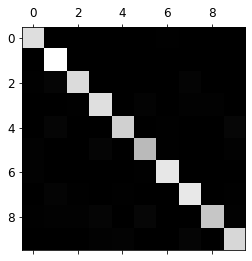

In [77]:
plot_conf_mat(conf_mat)

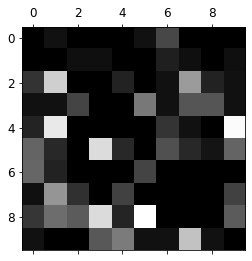

In [78]:
plot_conf_mat(conf_mat_err(conf_mat))

In [79]:
X_train_slice = X_train[:10000]
y_train_slice = y_train[:10000]

X_test_slice  = X_train[15000:20000]
y_test_slice  = y_train[15000:20000] 

In [80]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train_slice, y_train_slice)

KNeighborsClassifier()

In [81]:
y_pred_class = knn_clf.predict(X_test_slice)
accuracy_score(y_test_slice, y_pred_class)

0.9522

In [82]:
conf_mat = get_conf_mat(y_test_slice, y_pred_class)

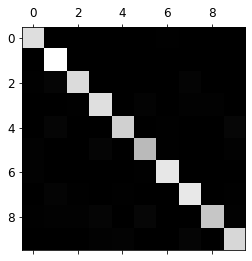

In [83]:
plot_conf_mat(conf_mat)

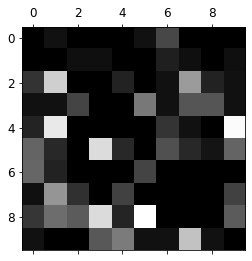

In [84]:
plot_conf_mat(conf_mat_err(conf_mat))

In [85]:
# We can see that this model missclasify the same 4's as 9's
# But, it does other mistakes

In [91]:
# Let's stick for now to RandomForestClassifier and KNearestNeighbors

# Until now, we have the data as follows:
# (X_train, y_train) and (X_test, y_test) (test = 20% * train)

In [92]:
# Let's try to combine the 'forest_clf' and 'knn_clf'

In [93]:
from sklearn.ensemble import VotingClassifier

estimators = [('forest', forest_clf), ('knn', knn_clf)]
ensemble = VotingClassifier(estimators, voting='soft')

In [94]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [95]:
ensemble_pred = ensemble.predict(X_test)

In [96]:
accuracy_score(y_test, ensemble_pred)

0.9740714285714286

In [97]:
# We have the best predictor until now
best_model = ensemble
best_model

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [98]:
# Let's try a sort of data augmentation

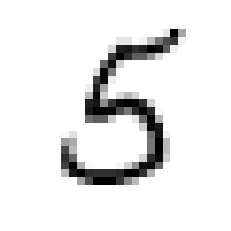

In [99]:
plot_digit(X_train[0])

In [100]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx=0, dy=0):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [101]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

In [110]:
# Shift the images
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [ ]:
# Rotate the image by theta degrees
def rotate_image(image, theta=0):
    image = image.reshape((28, 28))
    rotated_image = rotate(image, theta, reshape=False)
    return rotated_image.reshape([-1])

In [111]:
# Transform in numpy array
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [112]:
X_train_augmented.shape

(280000, 784)

In [113]:
# Let's shuffle the data because when we did augmentation,
# original digit and 4 augmented images are placed consecutively
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [114]:
best_model.fit(X_train_augmented, y_train_augmented)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [115]:
aug_pred = best_model.predict(X_test)

In [116]:
accuracy_score(y_test, aug_pred)

0.9822142857142857

In [135]:
from scipy.ndimage.interpolation import rotate

# Rotate the image by theta degrees
def rotate_image(image, theta=0):
    print(theta)
    image = image.reshape((28, 28))
    rotated_image = rotate(image, theta, reshape=False)
    return rotated_image.reshape([-1])

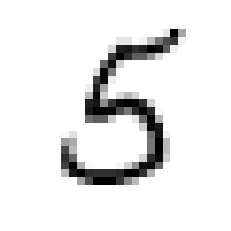

In [136]:
plot_digit(X_train[0])

In [120]:
samples = 10 # number of random angles
angles  = np.random.uniform(-30, 30, samples)

# Transform in list
X_train_augmented = X_train_augmented.tolist()
y_train_augmented = y_train_augmented.tolist()

for angle in angles:
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(rotate_image(image, angle))
        y_train_augmented.append(label)

In [150]:
# Transform in numpy array
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
X_train_augmented.shape

In [125]:
y_train_augmented.shape

(840000,)

In [123]:
# Let's shuffle the data because when we did augmentation,
# original digit and 10 rotated images are placed consecutively
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [4]:
# ...

In [7]:
### TITANIC ###

In [8]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()  

In [25]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    path = titanic_path + "\\" + filename
    return pd.read_csv(path)

In [26]:
train = load_titanic_data("train.csv")
test  = load_titanic_data("test.csv")

In [27]:
type(train)

pandas.core.frame.DataFrame

In [28]:
type(test)

pandas.core.frame.DataFrame

In [29]:
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

In [30]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Saving figure scatter_matrix_plot


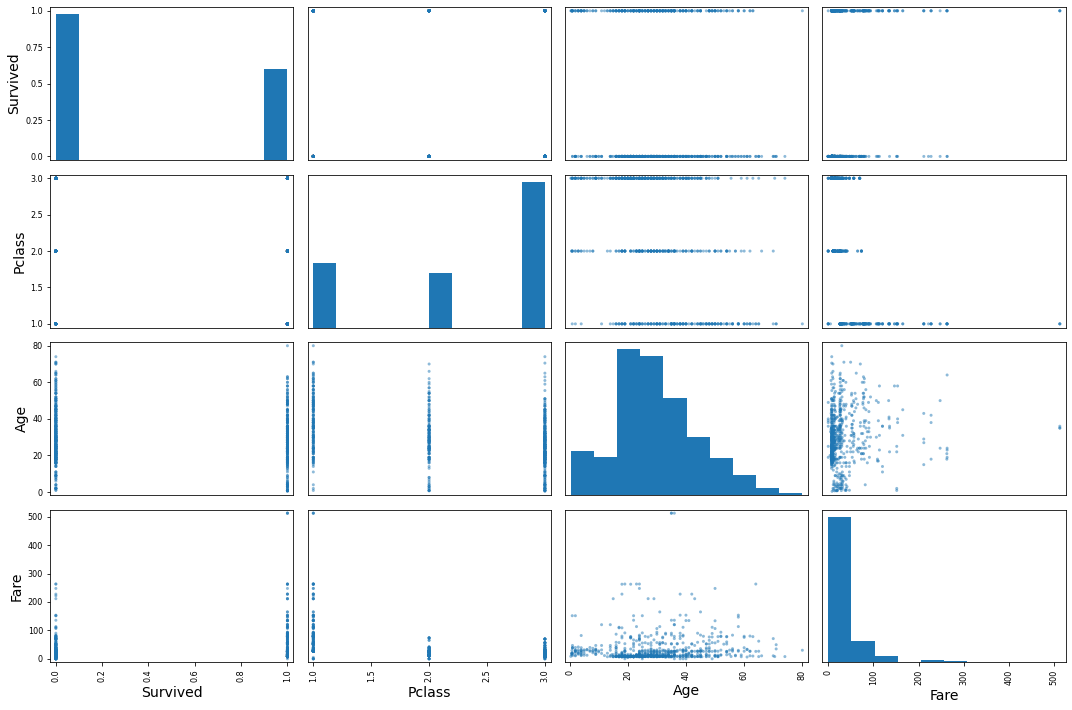

In [39]:
# Plot some correlations between different attributes
from pandas.plotting import scatter_matrix

attrs = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare']
scatter_matrix(train[attrs], figsize=(15, 10))
save_fig("scatter_matrix_plot")

In [40]:
# This scatter matrix isn't very useful in this case

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [45]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [46]:
# Cabin has a lot of NaNs, so we can drop it
train.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)

In [48]:
# Let's also drop the Parch, Ticket and Name
train.drop(columns=['Parch', 'Ticket', 'Name'], inplace=True)
test.drop(columns=['Parch', 'Ticket', 'Name'], inplace=True)

In [49]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
PassengerId,,,,,,,
1,0,3,male,22.0,1,7.2500,S
2,1,1,female,38.0,1,71.2833,C
3,1,3,female,26.0,0,7.9250,S
4,1,1,female,35.0,1,53.1000,S
5,0,3,male,35.0,0,8.0500,S


In [50]:
test.head()

,Pclass,Sex,Age,SibSp,Fare,Embarked
PassengerId,,,,,,
892,3,male,34.5,0,7.8292,Q
893,3,female,47.0,1,7.0000,S
894,2,male,62.0,0,9.6875,Q
895,3,male,27.0,0,8.6625,S
896,3,female,22.0,1,12.2875,S


In [53]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Fare          0
Embarked      2
dtype: int64

In [54]:
test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Fare         1
Embarked     0
dtype: int64

In [55]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [57]:
corr_matrix = train.corr()
corr_matrix['Survived'].sort_values(ascending=False)
# Fare and Pclass are good indicators

Survived    1.000000
Fare        0.257307
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [58]:
# Let's drop the labels from the training set
y_train = train['Survived']
y_train = np.asarray(y_train)
train.drop(columns=['Survived'], inplace=True)

In [61]:
# Until now, we have (train, y_train), (test)

In [86]:
train.shape

(891, 6)

In [87]:
train.shape

(891, 6)

In [88]:
train.head()

,Pclass,Sex,Age,SibSp,Fare,Embarked
PassengerId,,,,,,
1,3,male,22.0,1,7.2500,S
2,1,female,38.0,1,71.2833,C
3,3,female,26.0,0,7.9250,S
4,1,female,35.0,1,53.1000,S
5,3,male,35.0,0,8.0500,S


In [80]:
num_attr = ['Pclass', 'Age', 'SibSp', 'Fare']
cat_attr = ['Sex', 'Embarked']

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

In [82]:
# Categorical attributes pipeline
cat_pipe = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')), # fill in the missing values
    ('one_hot_enc', OneHotEncoder(sparse=False)), # encode the categorical attributes
])

In [83]:
# Categorical attributes pipeline
num_pipe = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')), # fill in the missing values
    ('normalizer', Normalizer()),
])

In [84]:
transformer = ColumnTransformer([
    ('num', num_pipe, num_attr),
    ('cat', cat_pipe, cat_attr),
])

In [89]:
X_train = transformer.fit_transform(train[num_attr + cat_attr])
X_test  = transformer.transform(test[num_attr + cat_attr])

In [91]:
X_train[0]

array([0.12832206, 0.94102848, 0.04277402, 0.31011166, 0.        ,
       1.        , 0.        , 0.        , 1.        ])

In [93]:
train.head(1)

,Pclass,Sex,Age,SibSp,Fare,Embarked
PassengerId,,,,,,
1,3,male,22.0,1,7.25,S


In [94]:
X_train.shape

(891, 9)

In [97]:
y_train.shape

(891,)

In [98]:
X_test.shape

(418, 9)

In [90]:
# Until now, we have (X_train, y_train), (X_test)

In [100]:
# Let's try a T-SNE only for "clustering" visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=10000)

X_train_red = tsne.fit_transform(X_train)

In [101]:
X_train_red.shape

(891, 2)

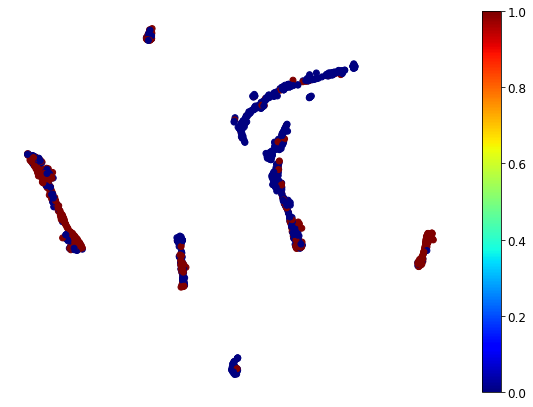

In [106]:
# Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit
plt.figure(figsize=(10, 7))
plt.scatter(X_train_red[:, 0], X_train_red[:, 1], c=y_train, cmap='jet')
plt.axis('off')
plt.colorbar()

In [ ]:
# Until now, we have (X_train, y_train), (X_test)

In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [110]:
# We can start trying different base models:
# -> LinearSVC
# -> KNClassifier
# -> RandomForestClassifier
# -> Voting classifier (ensemble)

In [130]:
# LinearSVC
from sklearn.svm import LinearSVC

svc_clf = LinearSVC()
svc_clf.fit(X_train, y_train)
y_pred  = svc_clf.predict(X_train)
svc_acc = accuracy_score(y_train, y_pred)
svc_acc

0.7833894500561167

In [131]:
# KNCLassifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred  = knn_clf.predict(X_train)
knn_acc = accuracy_score(y_train, y_pred)
knn_acc

0.8294051627384961

In [134]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
y_pred     = forest_clf.predict(X_train)
forest_acc = accuracy_score(y_train, y_pred)
forest_acc
# It seems to overfit the training set

0.9809203142536476

In [135]:
# VotingClassifier
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('svc', svc_clf),
    ('knn', knn_clf),
    ('forest', forest_clf),
], voting='hard')

In [136]:
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_train)
ensemble_acc = accuracy_score(y_train, y_pred)
ensemble_acc

0.8754208754208754

In [145]:
# Let's try to make a grid search on the ensemble classifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__penalty': ['l1', 'l2'],
    'svc__loss': ['hinge', 'squared_hinge'],
    'knn__n_neighbors': [5, 7, 9, 11],
    'forest__n_estimators': [100, 125, 150],
    'forest__max_depth': [10, 20, 30, None],
}

grid = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=2, n_jobs=-1, verbose=3)

In [146]:
grid.fit(X_train, y_train)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


F:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.76769033        nan 0.76095632        nan 0.77217967
        nan 0.76769285        nan 0.75311634        nan 0.75984532
        nan 0.75759561        nan 0.75311382        nan 0.77105104
        nan 0.76544566        nan 0.77666398        nan 0.77106112
        nan 0.75872676        nan 0.75760568        nan 0.75759813
        nan 0.74975311        nan 0.76881141        nan 0.76544314
        nan 0.77442435        nan 0.77330327        nan 0.75984532
        nan 0.75760316        nan 0.75760064        nan 0.75535597
        nan 0.76095884        nan 0.76207739        nan 0.77666398
        nan 0.76769537        nan 0.75984784        nan 0.75536101
        nan 0.76095884        nan 0.75311382        nan 0.76431954
        nan 0.76431954        nan 0.77105608        nan 0.76994004
        nan 0.76096891        nan 0.75648461        nan 0.7564770

GridSearchCV(cv=2,
             estimator=VotingClassifier(estimators=[('svc', LinearSVC()),
                                                    ('knn',
                                                     KNeighborsClassifier()),
                                                    ('forest',
                                                     RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [10, 20, 30, None],
                         'forest__n_estimators': [100, 125, 150],
                         'knn__n_neighbors': [5, 7, 9, 11],
                         'svc__loss': ['hinge', 'squared_hinge'],
                         'svc__penalty': ['l1', 'l2']},
             verbose=3)

In [147]:
grid.best_params_

{'forest__max_depth': None,
 'forest__n_estimators': 150,
 'knn__n_neighbors': 7,
 'svc__loss': 'hinge',
 'svc__penalty': 'l2'}

In [148]:
y_pred   = grid.predict(X_train)
grid_acc = accuracy_score(y_train, y_pred)
grid_acc

0.867564534231201

In [152]:
model = grid.best_estimator_
model

VotingClassifier(estimators=[('svc', LinearSVC(loss='hinge')),
                             ('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('forest',
                              RandomForestClassifier(n_estimators=150))])

In [153]:
# Now, we can use the model to predict on the test set

In [154]:
y_test_pred = model.predict(X_test)

In [166]:
# pd.DataFrame(y_test_pred).to_csv('titanic.csv')

In [ ]:
# This model receives 76% on kaggle